# User guide and example for the Landlab SPACE component

This notebook provides a brief introduction and user's guide for the Stream Power And Alluvial Conservation Equation (SPACE) component for landscape evolution modeling. It combines two documents, a User's Manual and a notebook-based example, written Charles M. Shobe to accompany the following publication:

Shobe, C. M., Tucker, G. E., & Barnhart, K. R. (2017). The SPACE 1.0 model: a Landlab component for 2-D calculation of sediment transport, bedrock erosion, and landscape evolution. Geoscientific Model Development, 10(12), 4577-4604, [https://doi.org/10.5194/gmd-10-4577-2017](https://doi.org/10.5194/gmd-10-4577-2017).

This notebook contains text from user manual along with executable code for its examples.

*(User's Manual and example notebook written by C.M. Shobe in July 2017; combined into a notebook, updated for compatibility with Landlab 2.x, and added to the Landlab tutorials collection by Greg Tucker, July 2021.)*

## Background on SPACE component

The Landlab SPACE (Stream Power with Alluvium Conservation and Entrainment) component computes sediment transport and bedrock erosion across two-dimensional model landscapes. The SPACE model provides advantages relative to many other fluvial erosion models in that it 1) allows simultaneous erosion of sediment and bedrock, 2) explicitly treats sediment fluxes rather than relying on a proxy for bed cover, and 3) is easily coupled with other surface process components in Landlab. The SPACE component enhances Landlab’s functionality by enabling modeling of bedrock-alluvial channels, rather than simply using parameterized sediment-flux-dependent incision models.

This user manual teaches users how to use the SPACE component using two
examples provided in Shobe et al. (2017).

This user manual serves as a supplement to that manuscript.
Prerequisites: A working knowledge of the Python programming language
(SPACE and Landlab support Python 3.x) as well as the NumPy
and MatPlotLib libraries. Basic familiarity with the Landlab modeling toolkit (see Hobley et al., 2017 GMD, and Barnhart et al., 2020 eSurf) is recommended.

## Model description

### Input parameters

- **Sediment erodibility** $K_s$: Governs the rate of sediment entrainment; may be specified as a single floating point number, an array of length equal to the number of grid nodes, or a string naming an existing grid field.

- **Bedrock erodibility** $K_r$: Governs the rate of bedrock erosion; may be specified as a single floating point number, an array of length equal to the number of grid nodes, or a string naming an existing grid field.

- **Fraction of fine sediment** $F_f$: The unitless fraction (0–1) of rock that does not get converted to sediment, but is assumed to exit the model domain as “fine sediment,” or wash load.

- **Sediment porosity** $\phi$: The unitless fraction (0–1) of sediment thickness caused by pore space.

- **Sediment entrainment length scale** $H_*$: Length scale governing the shape of the exponential sediment entrainment and bedrock erosion func- tions. $H_*$ may be thought of as reflecting bedrock surface roughness, with larger $H_*$ representing a rougher bedrock surface.

- **Effective settling velocity** $V$: Settling velocity of sediment after accounting for the upward effects of turbulence. For details, see discussion by Davy and Lague, 2009.

- **Stream power exponent** $m$: Exponent on drainage area or discharge in the stream power framework. Generally $\approx 0.5$.

- **Stream power exponent** $n$: Exponent on channel slope in the stream power framework. Generally $\approx 1$.

- **Sediment erosion threshold** $\omega_{cs}$: Threshold erosive power required to entrain sediment.

- **Bedrock erosion threshold** $\omega_{cr}$: Threshold erosive power required to erode bedrock.

- **Discharge field**: The field name or array to use for water discharge. The default is to use the grid field `surface_water__discharge`, which is simply drainage area multiplied by the default rainfall rate (1 m/yr). To use custom spatially/temporally varying rainfall, use `water__unit_flux_in` to specify water input to the `FlowAccumulator`.

- **Solver**: string indicating the solver to use. Options at present include:
  - 'basic' (default): explicit forward-time extrapolation. Simple but will become unstable if time step is too large.
  - 'adaptive': subdivides global time step as needed to prevent slopes from reversing and alluvium from going negative.

### Model Variables

Variables listed here are updated by the component at the grid locations listed. NOTE: because flow routing, calculation of discharge, and calculation of flow depth (if applicable) are handled by other Landlab components, variables such as water discharge and flow depth are not altered by the SPACE model and are not listed here.

- `soil__depth`, node, [m]: Thickness of soil (also called sediment or alluvium) at every node. The name “soil” was used to match existing Landlab components. Soil thickness is calculated at every node incorporating the effects of sediment entrainment and deposition and bedrock erosion.

- `sediment__flux`, node, [m$^3$/yr]: The volumetric flux of sediment at each node. Sediment flux is used to calculate sediment deposition rates.


## Steps of a SPACE model

Note: these steps are for a SPACE model that is not coupled to any other Landlab components. To see examples of how to couple Landlab components, please refer to the Landlab documentation: [http://landlab.github.io](http://landlab.github.io).

### Step 1: Import the necessary libraries 

The SPACE component is required, as are the model grid component and a flow routing component. It is generally a good idea to also include a depression handler such as `LakeMapperBarnes` or `DepressionFinderAndRouter`. These depression handlers route flow across flats or pits in a digital elevation model.

In [5]:
import matplotlib.pyplot as plt  # For plotting results; optional
import numpy as np

from landlab import RasterModelGrid  # Grid utility
from landlab import imshow_grid  # For plotting results; optional
from landlab.components import Space  # SPACE model
from landlab.components import DepressionFinderAndRouter, FlowAccumulator

Two Landlab components are essential to running the SPACE model: the model itself, and the `FlowAccumulator`, which calculates drainage pathways, topographic slopes, and surface water discharge across the grid. A depression handler, such as `DepressionFinderAndRouter`, is extremely useful if a grid is likely to have pits or closed depressions. For this reason, it is generally a good idea to use the DepressionFinderAndRouter in addition to the `FlowAccumulator`. However, it is not required.

In addition to the relevant process components, some Landlab utilities are required to generate the model grid (in this example `RasterModelGrid`) and to visualize output (`imshow_grid`). Note that while it is possible to visualize output through functionality in other libraries (e.g., matplotlib), `imshow_grid` provides a simple way to generate 2-D maps of model variables.

Most Landlab functionality requires the Numpy package for scientific computing in python. The matplotlib plotting library has also been imported to aid visualization of results.

### Step 2: Define the model domain and initial conditions

The SPACE component works on raster grids. For this example we will use a synthetic raster grid. An example and description of the Landlab raster model grid are given in (Shobe et al., 2017), with a more complete explanation offered in Hobley et al. (2017) and Barnhart et al. (2020). In addition to using user-defined, synthetic model grids, it is also possible to import digital elevation models for use as a model domain (see the tutorial *reading_dem_into_landlab*). In this example, we create a synthetic, square model domain by creating an instance of the RasterModelGrid. In this case, the domain will be a plane slightly tilted towards the lower-left (southwest) corner with random micro-scale topographic roughness to force flow convergence and channelization. The grid is composed of 20 rows and 20 columns for a total of 400 nodes, with user-defined spacing.

Once the grid has been created, the user defines a grid field to contain values of land surface elevation, and then imposes the desired initial condition topography on the model grid. In the case shown below, the field `topographic__elevation` is added to the model grid and given initial values of all zeros. After that, initial model topography is added to the field. To create a plane tilted to the southwest corner, which is referenced by $(x,y)$ coordinate pair (0,0), topographic elevation is modified to depend on the $x$ and $y$ coordinates of each grid node. Then, randomized micro-scale topographic roughness is added to the model grid. While not strictly necessary for the SPACE model to run, the micro-roughness allows flow convergence, channelization, and the development of realistic landscapes.

In this example, we initialize the model domain with 2 meters of sediment thickness at every core (non-boundary) node. The sediment thickness will shrink over time as water mobilizes and removes sediment. To do this, the fields `soil__depth` and `bedrock__elevation` must be added to the model grid. If they are not added, the SPACE model will create them. In that case, however, the default sediment thickness is zero and the default bedrock topography is simply the provided topographic elevation.

In [6]:
# Set grid parameters
num_rows = 20
num_columns = 20
node_spacing = 100.0

# track sediment flux at the node adjacent to the outlet at lower-left
node_next_to_outlet = num_columns + 1

# Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)
# add field ’topographic elevation’ to the grid
mg.add_zeros("topographic__elevation", at="node")
# set constant random seed for consistent topographic roughness
np.random.seed(seed=5000)

# Create initial model topography:
# plane tilted towards the lower−left corner
topo = mg.node_y / 100000.0 + mg.node_x / 100000.0

# add topographic roughness
random_noise = (
    np.random.rand(len(mg.node_y)) / 1000.0
)  # impose topography values on model grid
mg["node"]["topographic__elevation"] += topo + random_noise

# add field 'soil__depth' to the grid
mg.add_zeros("soil__depth", at="node")

# Set 2 m of initial soil depth at core nodes
mg.at_node["soil__depth"][mg.core_nodes] = 2.0  # meters

# Add field 'bedrock__elevation' to the grid
mg.add_zeros("bedrock__elevation", at="node")

# Sum 'soil__depth' and 'bedrock__elevation'
# to yield 'topographic elevation'
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"]
mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

### Step 3: Set the boundary conditions

The user must determine the boundary conditions of the model domain (i.e., determine across which boundaries water and sediment may flow). Boundary conditions are controlled by setting the status of individual nodes or grid edges (see Hobley et al., 2017). We will use a single corner node as an “open” boundary and all other boundary nodes will be “closed”. We first use set closed boundaries at grid edges to ensure that no mass (water or sediment) may cross the model boundaries. Then, set watershed boundary condition outlet id is used to open (allow flow through) the lower-left corner of the model domain.

In [7]:
# Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True, left_is_closed=True, right_is_closed=True, top_is_closed=True
)

# Set lower-left (southwest) corner as an open boundary
mg.set_watershed_boundary_condition_outlet_id(
    0, mg["node"]["topographic__elevation"], -9999.0
)

In this configuration, the model domain is set to drain water and sediment out of the only open boundary on the grid, the lower-left corner. There are several options for changing boundary conditions in Landlab. See Hobley et al. (2017) or the Landlab [online documentation](https://landlab.csdms.io).

### Step 4: Initialize the SPACE component and any other components used

Like most Landlab components, SPACE is written as a Python class. The class was imported at the beginning of the driver script (step 1). In this step, the user declares the instance of the SPACE class and sets any relevant model parameters. The same must be done for any other components used.

In [9]:
# Instantiate flow router
fr = FlowAccumulator(mg, flow_director="FlowDirectorD8")

# Instantiate depression finder and router; optional
df = DepressionFinderAndRouter(mg)

# Instantiate SPACE model with chosen parameters
sp = Space(
    mg,
    K_sed=0.01,
    K_br=0.001,
    F_f=0.0,
    phi=0.0,
    H_star=1.0,
    v_s=5.0,
    m_sp=0.5,
    n_sp=1.0,
    sp_crit_sed=0,
    sp_crit_br=0,
)

### Step 5: Run the time loop

The SPACE component calculates sediment entrainment and deposition, bedrock erosion, and changes in land surface elevation over time. The code shown below is an example of how to run the SPACE model over several model timesteps. In the example below, SPACE is run in a loop that executes until elapsed model time has reached a user-defined run time. The user is also responsible for choosing the model timestep. Within the loop, the following steps occur:

1. The flow router runs first to determine topographic slopes and water discharge at all nodes on the model domain.
2. The depression finder and router runs to map any nodes located in local topographic minima (i.e., nodes that water cannot drain out of) and to establish flow paths across the surface of these “lakes.” Using the depression finder and router is optional. However, because the SPACE model may in certain situations create local minima, using the depression finder and router can prevent the development of fatal instabilities.
3. The depression finder and router generates a list of flooded nodes, which is then saved as a variable called “flooded” and passed to the SPACE model.
4. The SPACE model runs for the duration of a single timestep, computing sediment transport, bedrock erosion, and topographic surface evolution.
5. The elapsed time is updated.

In [10]:
# Set model timestep
timestep = 1.0  # years

# Set elapsed time to zero
elapsed_time = 0.0  # years

# Set timestep count to zero
count = 0

# Set model run time
run_time = 500.0  # years

# Array to save sediment flux values
sed_flux = np.zeros(int(run_time // timestep))

while elapsed_time < run_time:  # time units of years
    # Run the flow router
    fr.run_one_step()

    # Run the depression finder and router; optional
    df.map_depressions()

    # Run SPACE for one time step
    sp.run_one_step(dt=timestep)

    # Save sediment flux value to array
    sed_flux[count] = mg.at_node["sediment__flux"][node_next_to_outlet]

    # Add to value of elapsed time
    elapsed_time += timestep

    # Increase timestep count
    count += 1

## Visualization of results

### Sediment flux map

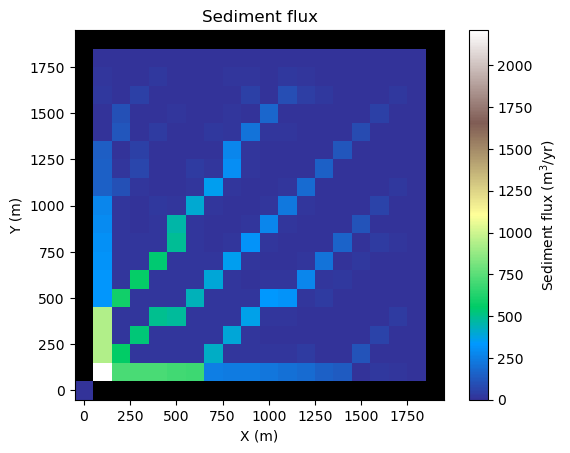

In [11]:
# Instantiate figure
fig = plt.figure()

# Instantiate subplot
plot = plt.subplot()

# Show sediment flux map
imshow_grid(
    mg,
    "sediment__flux",
    plot_name="Sediment flux",
    var_name="Sediment flux",
    var_units=r"m$^3$/yr",
    grid_units=("m", "m"),
    cmap="terrain",
)

In [ ]:
# Export figure to image
fig.savefig("sediment_flux_map.eps")

### Sedimentograph

Once the data required for the time series has been saved during the time loop, the time series may be plotted using standard matplotlib plotting commands:

In [ ]:
# Instantiate figure
fig = plt.figure()

# Instantiate subplot
sedfluxplot = plt.subplot()

# Plot data
sedfluxplot.plot(np.arange(500), sed_flux, color="k", linewidth=3.0)

# Add axis labels
sedfluxplot.set_xlabel("Time [yr]")
sedfluxplot.set_ylabel(r"Sediment flux [m$^3$/yr]")

There is an initial increase in sediment flux from the model domain as the water reaches its equilibrium transport capacity. Over the long run, topographic gradients are reduced by the erosion of sediment, which results in lower and lower sediment fluxes from the domain over time.